In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)


<module 'pkg_resources' from 'c:\\users\\hp\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\pkg_resources\\__init__.py'>

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')


In [3]:
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper

In [4]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [5]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

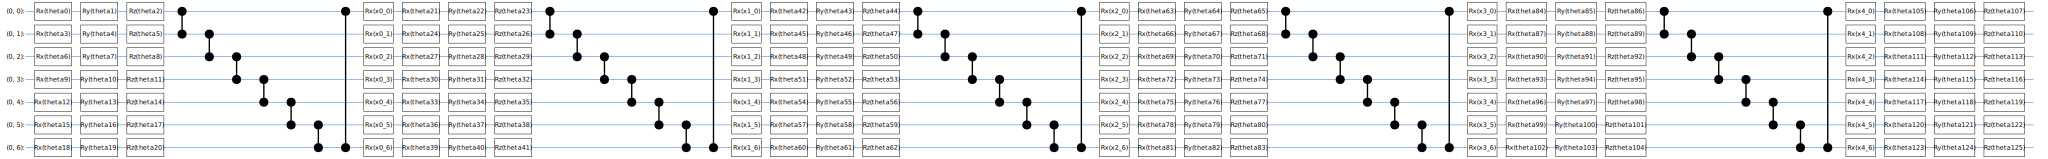

In [6]:
n_qubits, n_layers = 8, 3
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [7]:
def make_variables(initializer):
    with tf.Session() as sess:
        print(initializer.eval()) 

# v1 = make_variables(tf.random_uniform_initializer(minval=0.0, maxval=np.pi))

# print(v1)

In [8]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)
        
        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        
        
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
        
        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        #print(tiled_up_circuits)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

In [9]:
class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))

In [10]:
n_qubits = 8 # Dimension of the state vectors in CartPole
n_layers = 3 # Number of layers in the PQC
n_actions = 4 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [ops[0]*ops[4], ops[1]*ops[5], ops[2]*ops[6], ops[3]*ops[7]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

In [11]:
def generate_model_Qlearning(qubits, n_layers, n_actions, observables, target):
    """Generates a Keras model for a data re-uploading PQC Q-function approximator."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables, activation='tanh')([input_tensor])
    process = tf.keras.Sequential([Rescaling(len(observables))], name=target*"Target"+"Q-values")
    Q_values = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=Q_values)

    return model

model = generate_model_Qlearning(qubits, n_layers, n_actions, observables, False)
model_target = generate_model_Qlearning(qubits, n_layers, n_actions, observables, True)
model_target.set_weights(model.get_weights())


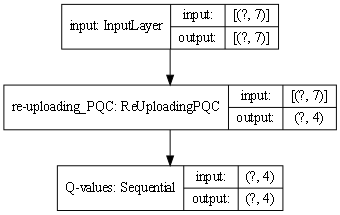

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

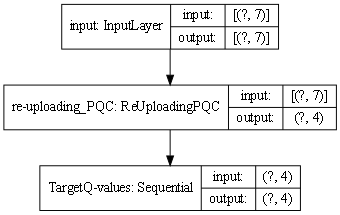

In [13]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

In [14]:
def interact_env(state, model, epsilon, n_actions, env):
    # Preprocess state
    state_array = np.array(state) 
    state = tf.convert_to_tensor([state_array])

    # Sample action
    coin = np.random.random()
    if coin > epsilon:
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else:
        action = np.random.choice(n_actions)

    # Apply sampled action in the environment, receive reward and next state
    next_state, reward, done, _ = env.step(action)

    interaction = {'state': state_array, 'action': action, 'next_state': next_state.copy(),
                   'reward': reward, 'done':float(done)}

    return interaction


In [15]:
@tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, gamma, n_actions):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                   * (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)

    # Backpropagation
    #print(model.trainable_variables[0].numpy())
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])


In [16]:
gamma = 0.9
n_episodes = 5000

# Define replay memory
max_memory_length = 100000 # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.09  # Minimum epsilon greedy parameter
decay_epsilon = 0.00009 # Decay rate of epsilon greedy parameter
batch_size = 32
steps_per_update = 5 # Train the model every x steps


In [17]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2


In [18]:
env_name = "Environment.exe"
env = UnityEnvironment(file_name=env_name, worker_id = 1, seed=1, side_channels=[])
env = UnityToGymWrapper(env)

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state = env.reset()
    step_count = 0
    while True:
        # Interact with env
        interaction = interact_env(state, model, epsilon, n_actions, env)
        if(not(interaction['done'])):
            # Store interaction in the replay memory
            replay_memory.append(interaction)

            state = interaction['next_state']
            episode_reward += interaction['reward']
            step_count += 1

            # Update model
            if step_count % steps_per_update == 0:
            # Sample a batch of interactions and update Q_function
                training_batch = np.random.choice(replay_memory, size=batch_size)
                Q_learning_update(np.asarray([x['state'] for x in training_batch]),
                              np.asarray([x['action'] for x in training_batch]),
                              np.asarray([x['reward'] for x in training_batch], dtype=np.float32),
                              np.asarray([x['next_state'] for x in training_batch]),
                              np.asarray([x['done'] for x in training_batch], dtype=np.float32),
                              model, gamma, n_actions)


        # Check if the episode is finished
        else:
            # Update target model
            if step_count % steps_per_target_update == 0:
                model_target.set_weights(model.get_weights())
                
            # Store interaction in the replay memory
            replay_memory.append(interaction)
            episode_reward += interaction['reward']
            step_count += 1
            break

        
    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    if (episode+1)%10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(
            episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 9.0:
            break


<>:1: DeprecationWarning: invalid escape sequence \B
2023-04-09 13:15:35 INFO [environment.py:111] Connected to Unity environment with package version 1.0.8 and communication version 1.0.0
2023-04-09 13:15:36 INFO [environment.py:342] Connected new brain:
BallBalance?team=0


UnityCommunicatorStoppedException: Communicator has exited.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()